# Model Summary 
## The goals of this model:
* Sentiment analysis of Tweets 
* Predidct positive/ neutral/negative signals of BTC price
* Label future Tweets

## Approach
* NLP and sentimental analysis 
* Bi-directional LSTM model

## Data 
* BTC price 
* Tweets 

1. Sample the data randomly and normlize the data. 
2. Find the derivative of BTC prices and define their positive/negative/neutral signals 
3. Defind a classification problem that predicts the movement
4. use the model to further label data

In [4]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
! pip install vaderSentiment

In [5]:
# download stopwords
import  nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yedih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [92]:
from time import sleep
import json
import pandas as pd
import io
import re
import numpy as np
from tqdm import tqdm
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import preprocessing
import matplotlib.pyplot as plt
# from plotly.offline import init_notebook_mode, iplot
# import plotly.graph_objs as go
# init_notebook_mode(connected=True) 

In [93]:
tweets_raw_file   = './Bitcoin_tweets.csv'
tweets_clean_file = './Bitcoin_tweets_clean.csv'
bit_price_file2 = './BTC-USD.csv'
# bit_price_file2 = 'data/BTC-USD.csv'

In [94]:
# limit reading for testing
df_raw = pd.read_csv(tweets_raw_file,low_memory=False,nrows= 10000000)
#df_raw = pd.read_csv(tweets_raw_file,low_memory=False)
print(df_raw.shape)
# show the first 5 rows
df_raw.head(5)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [115]:
# clean df
# order by date
df_raw = df_raw.sort_values(by = 'date')
# 1% random sample, not allow duplicate
dd = df_raw.sample(frac=0.01, replace=False, random_state=1)
#dd = df_raw.sample(frac=0.02, replace=False, random_state=1)
dd.reset_index(inplace=True)
# load stopwords files
stop_words = set(stopwords.words('english'))

for i,s in enumerate(tqdm(dd['text'],position=0, leave=True)):
    text = str(dd.loc[i, 'text'])
    text = text.replace("#", "")
    # remove URL
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
    # remove 'at'
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    # remove stopwords
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    text = ' '.join(filtered_sentence)
    dd.loc[i, 'text'] = text
# f = open(tweets_clean_file, 'a+', encoding='utf-8')
dd.to_csv(tweets_clean_file, header=True, encoding='utf-8',index=False)

100%|██████████| 100000/100000 [03:24<00:00, 488.54it/s]


## Sentiment anatweets_clean_fileh Vader
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

Use vader to calculate polarity

In [95]:
df_clean = pd.read_csv(tweets_clean_file)
df_clean.dropna(subset=['text'], inplace=True)

In [96]:
analyzer = SentimentIntensityAnalyzer()
compound = []
for i,s in enumerate(tqdm(df_clean['text'],position=0, leave=True)):
    # print(i,s)
    vs = analyzer.polarity_scores(str(s))
    compound.append(vs["compound"])
df_clean["compound"] = compound
df_clean.head(2)

100%|██████████| 45664/45664 [00:03<00:00, 11795.62it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound
0,3556230,Kyle Schneps,"New York, USA","Director of Public Policy at @FoundryServices,...",2021-10-23 13:16:01,404.0,261.0,3083.0,False,2022-06-15 16:20:38,"enter economic downturn , jobs underserved are...","['Bitcoin', 'BTC', 'Veto']",Twitter for iPhone,False,0.5574
1,4471288,Ⓜ️el-The-Hexican,Metaverse,"RH Ecosystem maxi. All opinions are mine, and ...",2009-04-01 13:04:29,792.0,591,13399,False,2022-11-16 21:17:59,Crypto Strategy ICONOMI outperformed BTC . Che...,"['btc', 'bitcointrading', 'bitcoin', 'bitcoinm...",iconomi.com,False,0.0000


## Calculate a score for each tweet
To calculate the score for each tweet, we use different variables to which we had a weight based on its importance.

The compound column represents the sentiment of the tweets and its value is between -1 and 1.

We also use the number of retweets, the number of likes, and the number of users that follow the tweet's author.

In [97]:
scores = []
for i, s in tqdm(df_clean.iterrows(), total=df_clean.shape[0],position=0, leave=True):
    try:
        # polarity x number of user followers x (favourite + 1)/(followers+1) * (retweets + 1)
        scores.append(s["compound"] * ((int(s["user_followers"]))) * ((int(s["user_favourites"])+1)/int(s['user_followers']+1)) *((int(s["is_retweet"])+1)))
    except:
        # if error, nan
        scores.append(np.nan)
df_clean["score"] = scores
df_clean.head(2)

100%|██████████| 45664/45664 [00:01<00:00, 27734.76it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound,score
0,3556230,Kyle Schneps,"New York, USA","Director of Public Policy at @FoundryServices,...",2021-10-23 13:16:01,404.0,261.0,3083.0,False,2022-06-15 16:20:38,"enter economic downturn , jobs underserved are...","['Bitcoin', 'BTC', 'Veto']",Twitter for iPhone,False,0.5574,NaN
1,4471288,Ⓜ️el-The-Hexican,Metaverse,"RH Ecosystem maxi. All opinions are mine, and ...",2009-04-01 13:04:29,792.0,591,13399,False,2022-11-16 21:17:59,Crypto Strategy ICONOMI outperformed BTC . Che...,"['btc', 'bitcointrading', 'bitcoin', 'bitcoinm...",iconomi.com,False,0.0000,0.0


## read Bitcoin price 

In [98]:
df_price = pd.read_csv(bit_price_file2)
df_price.Date = pd.to_datetime(df_price.Date)
# df_price.Timestamp = pd.to_datetime(df_price.Timestamp,unit='s')
df_price.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200


In [99]:
# sentiment analysis 
df_clean = df_clean.drop_duplicates()
# date as index
tweets = df_clean.copy()
tweets['date'] = pd.to_datetime(tweets['date'],utc=True)
tweets.date = tweets.date.dt.tz_localize(None)
tweets.index = tweets['date']

# resample for every hour
# tweets_grouped = tweets.groupby(pd.TimeGrouper('1h'))['score'].sum()
tweets_grouped = tweets.resample('1h').sum()

tweets_grouped.head(2)

crypto_usd = df_price.copy()
crypto_usd['Date'] = pd.to_datetime(crypto_usd['Date'], unit='s')
crypto_usd.index = crypto_usd['Date']
# crypto_usd['Timestamp'] = pd.to_datetime(crypto_usd['Timestamp'], unit='s')
# crypto_usd.index = crypto_usd['Timestamp']

# crypto_usd_grouped = crypto_usd.groupby(pd.TimeGrouper('1h'))['Weighted_Price'].mean()
# resample for every day
crypto_usd_grouped = crypto_usd.resample('D')['Close'].mean()
crypto_usd_grouped.head(2)

Date
2014-09-17    457.334015
2014-09-18    424.440002
Freq: D, Name: Close, dtype: float64

In [100]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corrwith(datay.shift(lag), method=method)['score']
# xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, m ='pearson' ) for i in range(-20,20)]
# tweets_grouped.corrwith(crypto_usd_grouped,method='pearson')

In [101]:
# select overlapping data
begin = max(tweets_grouped.index.min().replace(tzinfo=None), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max().replace(tzinfo=None), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[begin:end]
crypto_usd_grouped = crypto_usd_grouped[begin:end]

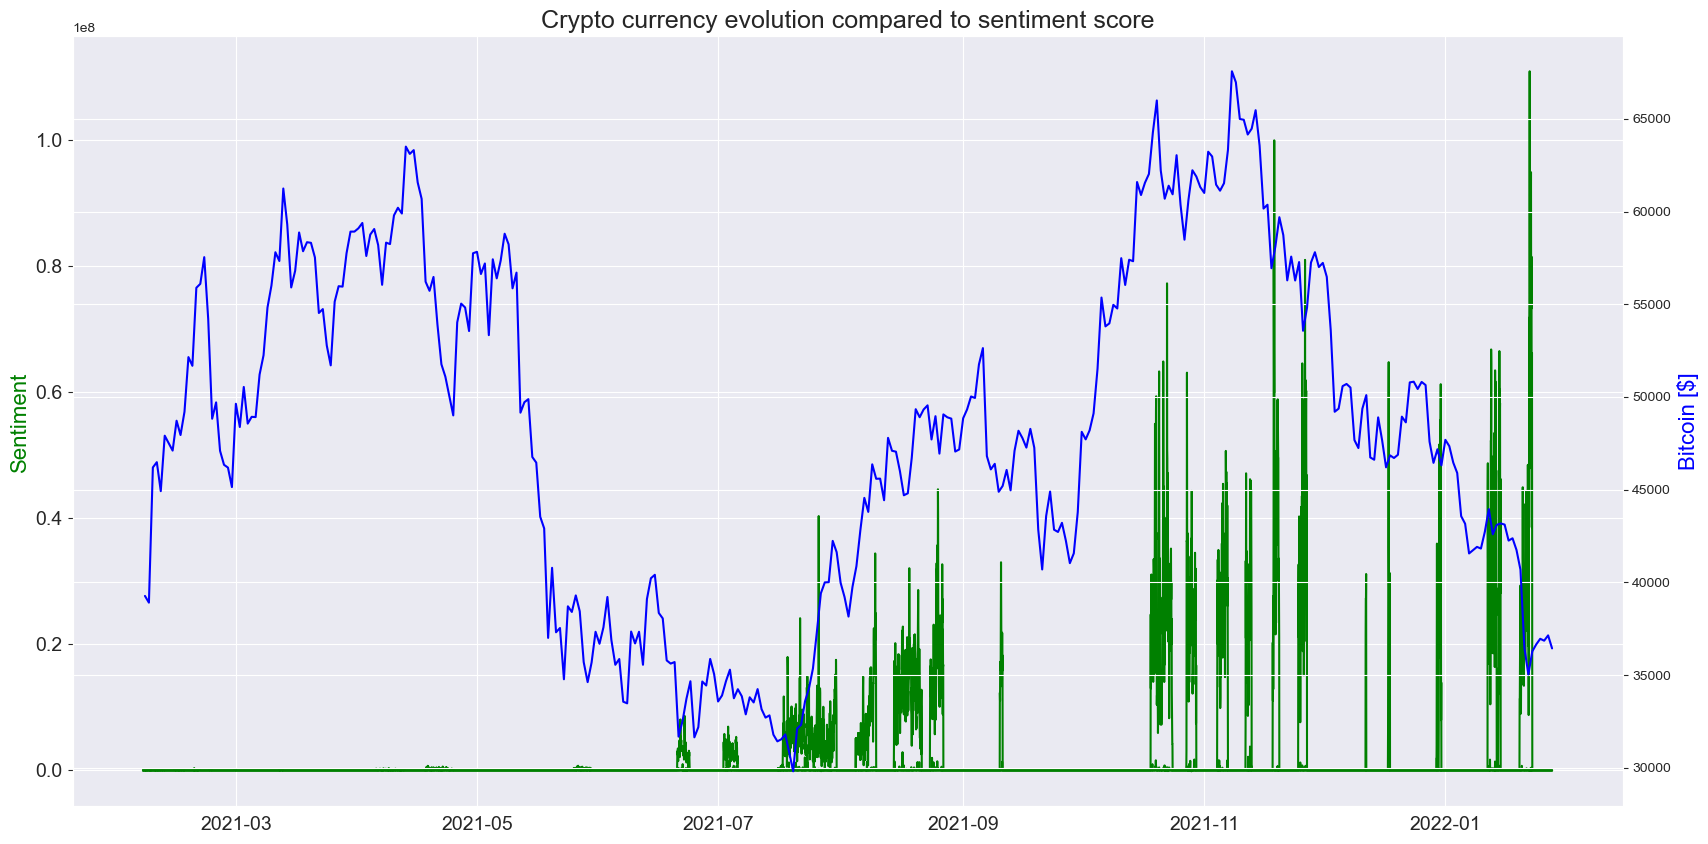

In [102]:
# cross correlation analysis
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to sentiment score", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)
plt.show()

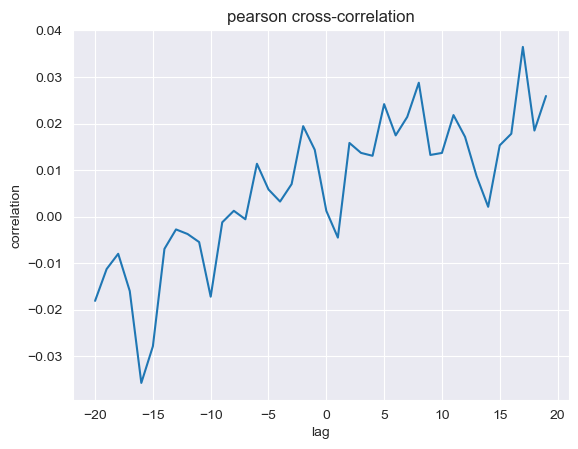

In [103]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()


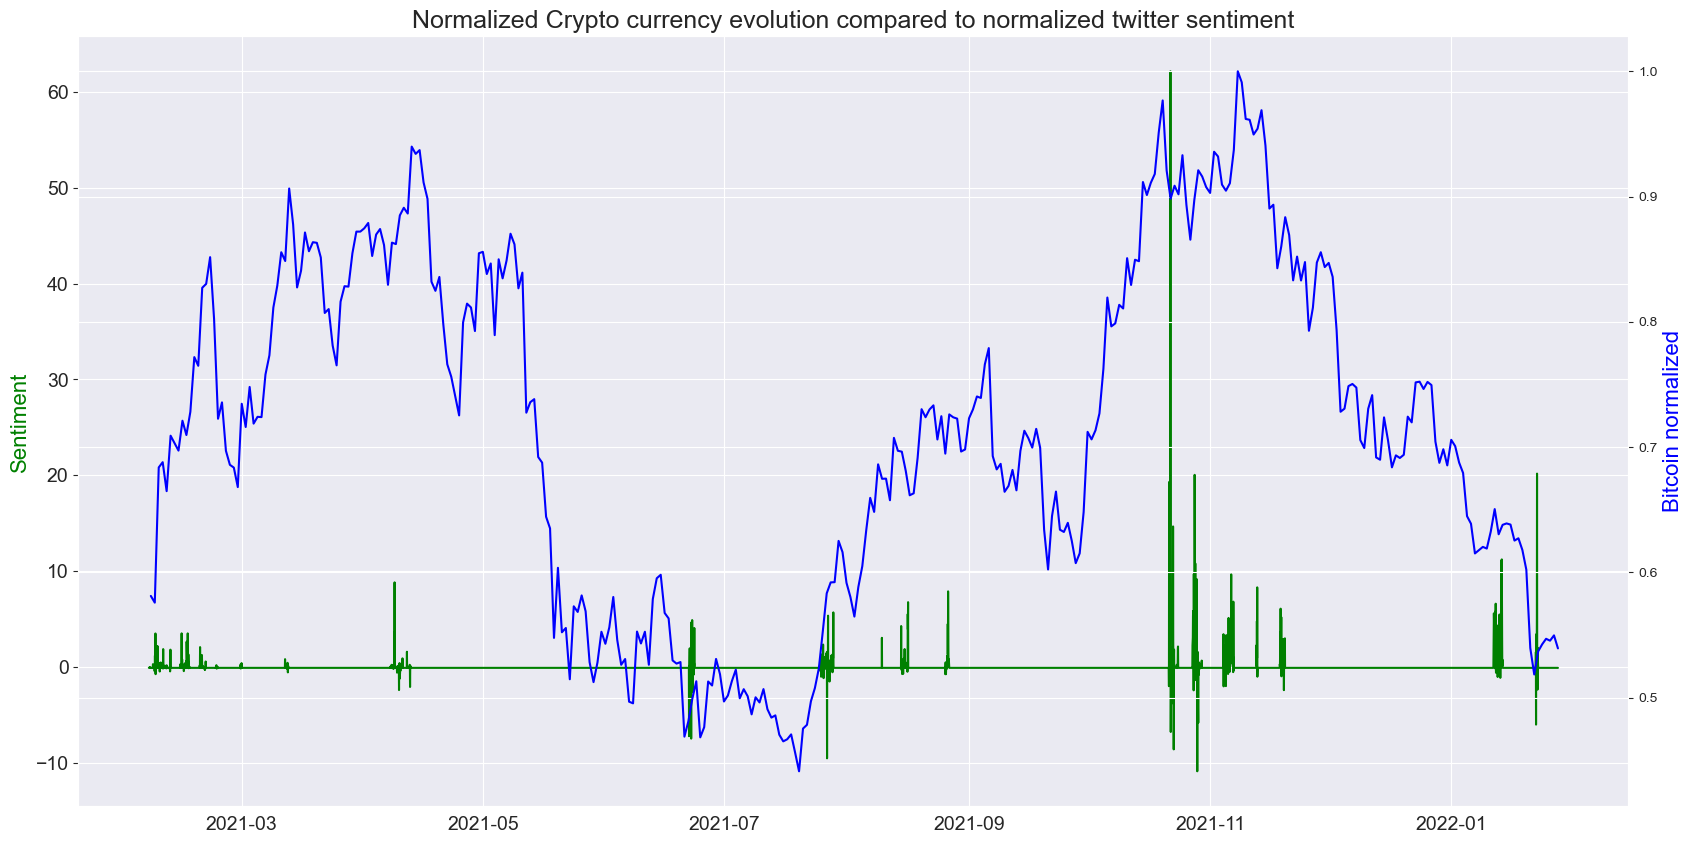

In [104]:
# # Normalize time series data
# min_max_scaler = preprocessing.StandardScaler()
# score_scaled = min_max_scaler.fit_transform(tweets_grouped['score'].values.reshape(-1,1))
# tweets_grouped['normalized_score'] = score_scaled
# # crypto_used_grouped_scaled = min_max_scaler.fit_transform(crypto_usd_grouped.values.reshape(-1,1))
# crypto_used_grouped_scaled = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))
# # crypto_usd_grouped['normalized_price'] = crypto_used_grouped_scaled
#
# fig, ax1 = plt.subplots(figsize=(20,10))
# ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
# ax1.tick_params(labelsize=14)
#
# ax2 = ax1.twinx()
# ax1.plot_date(tweets_grouped.index, tweets_grouped['normalized_score'], 'g-')
# ax2.plot_date(crypto_usd_grouped.index, crypto_used_grouped_scaled, 'b-')
#
# ax1.set_ylabel("Sentiment", color='g', fontsize=16)
# ax2.set_ylabel("Bitcoin normalized", color='b', fontsize=16)
# plt.show()

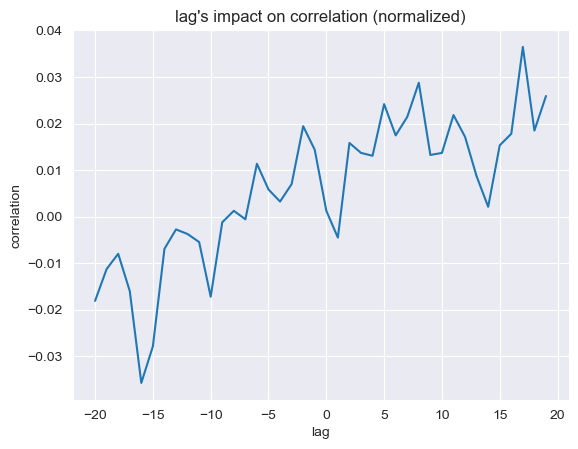

In [106]:
# #tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
# #tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
# xcov = [crosscorr(tweets_grouped, crypto_used_grouped_scaled, lag=i, method="pearson") for i in range(-20,20)]
# plt.plot(range(-20,20), xcov)
# plt.title("lag's impact on correlation (normalized)")
# plt.xlabel("lag")
# plt.ylabel("correlation")
# plt.show()

# Part 2 NLP Modeling

In [ ]:
! pip install textblob

In [13]:
from textblob import TextBlob

df = df_clean.copy()
# remove missing tag
df.dropna(subset=['hashtags'], inplace=True)
df = df[['text','user_followers','user_favourites','is_retweet']]
df = df.rename(columns = {'text':'tweets'})
# keeps textual features
df.head()

,tweets,user_followers,user_favourites,is_retweet
0,"enter economic downturn , jobs underserved are...",404.0,3083.0,False
1,Crypto Strategy ICONOMI outperformed BTC . Che...,792.0,13399,False
5,2 Cryptocurrencies Trounced bitcoin Shiba Inu ...,64362.0,9004,False
6,zesty faucet making tweet claim free Lightning...,262.0,613.0,False
10,believe faithful project.The projector lot att...,12.0,1276.0,False


In [14]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words(['english'])


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yedih\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yedih\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yedih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

def cleaning(data):
    #remove urls
    tweet_without_url = re.sub(r'http\S+',' ', data)

    #remove hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

    #3. Remove mentions and characters that not in the English alphabets
    tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)

    #2. Tokenize
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)

    #3. Remove Puncs
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]

    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #5. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]

    #6. Joining
    return " ".join(text_cleaned)

In [16]:
df['cleaned_tweets'] = df['tweets'].apply(cleaning)
# get date
df['date'] = df_clean['date']
df['date_clean'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df.drop(columns='date',inplace=True)
df.head()

,tweets,user_followers,user_favourites,is_retweet,cleaned_tweets,date_clean
0,"enter economic downturn , jobs underserved are...",404.0,3083.0,False,enter economic downturn job underserved area c...,2022-06-15
1,Crypto Strategy ICONOMI outperformed BTC . Che...,792.0,13399,False,Crypto Strategy ICONOMI outperformed BTC Check...,2022-11-16
5,2 Cryptocurrencies Trounced bitcoin Shiba Inu ...,64362.0,9004,False,Cryptocurrencies Trounced bitcoin Shiba Inu Cr...,2022-01-12
6,zesty faucet making tweet claim free Lightning...,262.0,613.0,False,zesty faucet making tweet claim free Lightning...,2022-05-12
10,believe faithful project.The projector lot att...,12.0,1276.0,False,believe faithful project The projector lot att...,2021-07-03


In [17]:
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [18]:
def crypto_price_cate(score):
    if score < 1:
        return 'negative'
    elif score == 1:
        return 'neutral'
    else:
        return 'positive'
def observe_period(period):
    # shift 'period' days
    res = crypto_usd_grouped.shift(period)/crypto_usd_grouped
    # compare to 'period' days before, increase? decrease?
    res = res.apply(crypto_price_cate)
    return res 

time_sentiment = observe_period(2) # compare price ratio in 7 days. price_7_days_later/ price_now
# if exist, get time sentiment for cypto_sentiment, else nan
df['crypto_sentiment'] = df.date_clean.apply(lambda x: time_sentiment[x] if x in time_sentiment else np.nan)

In [19]:
# may takes time 
df['subjectivity'] = df['cleaned_tweets'].apply(getSubjectivity)
df['polarity'] = df['cleaned_tweets'].apply(getPolarity)
df.head()

,tweets,user_followers,user_favourites,is_retweet,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity
0,"enter economic downturn , jobs underserved are...",404.0,3083.0,False,enter economic downturn job underserved area c...,2022-06-15,NaN,0.40000,0.2
1,Crypto Strategy ICONOMI outperformed BTC . Che...,792.0,13399,False,Crypto Strategy ICONOMI outperformed BTC Check...,2022-11-16,NaN,0.00000,0.0
5,2 Cryptocurrencies Trounced bitcoin Shiba Inu ...,64362.0,9004,False,Cryptocurrencies Trounced bitcoin Shiba Inu Cr...,2022-01-12,negative,0.90000,0.6
6,zesty faucet making tweet claim free Lightning...,262.0,613.0,False,zesty faucet making tweet claim free Lightning...,2022-05-12,NaN,0.80000,0.4
10,believe faithful project.The projector lot att...,12.0,1276.0,False,believe faithful project The projector lot att...,2021-07-03,negative,0.38125,0.5


In [20]:
def getSentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'
df['sentiment'] = df['polarity'].apply(getSentiment)
df['target'] = df['sentiment'] == df['crypto_sentiment']
df.dropna(subset=['crypto_sentiment'], inplace=True)

df.head()

,tweets,user_followers,user_favourites,is_retweet,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity,sentiment,target
5,2 Cryptocurrencies Trounced bitcoin Shiba Inu ...,64362.0,9004,False,Cryptocurrencies Trounced bitcoin Shiba Inu Cr...,2022-01-12,negative,0.90000,0.600,positive,False
10,believe faithful project.The projector lot att...,12.0,1276.0,False,believe faithful project The projector lot att...,2021-07-03,negative,0.38125,0.500,positive,False
14,Bears optimistic Bitcoin long-time appreciatio...,31.0,4179,False,Bears optimistic Bitcoin long time appreciatio...,2021-07-26,negative,0.55800,-0.088,negative,True
18,Ben Verlander reflects Miguel Cabrera 's histo...,660.0,65.0,False,Ben Verlander reflects Miguel Cabrera historic...,2021-08-24,positive,0.05000,0.000,neutral,False
24,40 minutes btc bitcoin eth Ethereum NFTs NFT N...,85.0,118.0,False,minute btc bitcoin eth Ethereum NFTs NFT NFTCo...,2021-11-19,positive,0.00000,0.000,neutral,False


In [19]:
df.to_csv('./df_data.csv')

## Model preparation 

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import load_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [9]:
df = pd.read_csv('./df_data.csv')

In [10]:
df.head()

,Unnamed: 0,tweets,user_followers,user_favourites,is_retweet,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity,sentiment,target
0,5,2 Cryptocurrencies Trounced bitcoin Shiba Inu ...,64362.0,9004.0,False,Cryptocurrencies Trounced bitcoin Shiba Inu Cr...,2022-01-12,negative,0.90000,0.600,positive,False
1,10,believe faithful project.The projector lot att...,12.0,1276.0,False,believe faithful project The projector lot att...,2021-07-03,negative,0.38125,0.500,positive,False
2,14,Bears optimistic Bitcoin long-time appreciatio...,31.0,4179.0,False,Bears optimistic Bitcoin long time appreciatio...,2021-07-26,negative,0.55800,-0.088,negative,True
3,18,Ben Verlander reflects Miguel Cabrera 's histo...,660.0,65.0,False,Ben Verlander reflects Miguel Cabrera historic...,2021-08-24,positive,0.05000,0.000,neutral,False
4,24,40 minutes btc bitcoin eth Ethereum NFTs NFT N...,85.0,118.0,False,minute btc bitcoin eth Ethereum NFTs NFT NFTCo...,2021-11-19,positive,0.00000,0.000,neutral,False


## Models - Data load

In [47]:
X = df['cleaned_tweets']
y = pd.get_dummies(df['crypto_sentiment']).values
num_classes = df['crypto_sentiment'].nunique()

In [48]:
seed = 1 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17833,) (4459,) (17833, 2) (4459, 2)


## Model - 1 embeddings to cypto trend

In [49]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_test.to_csv('x_test.csv')
np.savetxt("y_test.csv", y_test, delimiter=",")
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [50]:
from tensorflow.keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(17833, 30) (4459, 30)


In [83]:
from keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM, GRU, SimpleRNN
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 32
epochs = 10

max_features = 20000
embed_dim = 100

weight_decay = 1e-4

np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dropout(0.25))

# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.25))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.25))

# model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(32)))
#model.add(Dropout(0.25))


# model.add(GRU(256, return_sequences=True))
# model.add(SimpleRNN(128))
# model.add(Dense(10))
# model.add(Dropout(0.25))

# model.add(LSTM(256))
# model.add(Dense(10))
# model.add(Dropout(0.25))

# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(256))
# model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.optimizer.learning_rate = 1e-4
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 gru (GRU)                   (None, 30, 256)           274944    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 2,325,536
Trainable params: 2,325,536
Non-

In [84]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [85]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/3
558/558 - 24s - loss: 0.6828 - accuracy: 0.5669 - val_loss: 0.6741 - val_accuracy: 0.5806 - 24s/epoch - 43ms/step
Epoch 2/3
558/558 - 22s - loss: 0.6292 - accuracy: 0.6390 - val_loss: 0.6586 - val_accuracy: 0.5858 - 22s/epoch - 39ms/step
Epoch 3/3
558/558 - 22s - loss: 0.4752 - accuracy: 0.7740 - val_loss: 0.7328 - val_accuracy: 0.5945 - 22s/epoch - 39ms/step


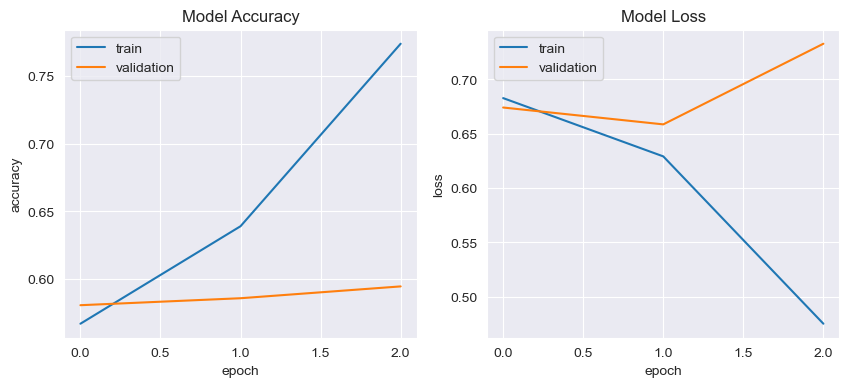

In [86]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [87]:
# predict class with test set
model.save('gru-trend')
y_pred_test = np.argmax(model.predict(X_test), axis=1)
np.savetxt("gru-trend_predict.csv", y_pred_test, delimiter=",")
np.savetxt("y_predict_1.csv", y_pred_test, delimiter=",")
print('Accuracy:\t{:0.3f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
print(classification_report(np.argmax(y_test,axis=1), y_pred_test, digits = 4))

INFO:tensorflow:Assets written to: gru-trend\assets


INFO:tensorflow:Assets written to: gru-trend\assets


140/140 [==============================] - 2s 11ms/step
Accuracy:	59.453%
              precision    recall  f1-score   support

           0     0.5319    0.4992    0.5150      1923
           1     0.6372    0.6668    0.6516      2536

    accuracy                         0.5945      4459
   macro avg     0.5845    0.5830    0.5833      4459
weighted avg     0.5917    0.5945    0.5927      4459



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

## Model - 2 bows to cypto trend

(17833,) (4459,) (17833, 2) (4459, 2)
(17833, 34805) (4459, 34805)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                556896    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 557,202
Trainable params: 557,202
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/d

E:\conda\envs\mlp\lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


558/558 - 3s - loss: 0.6812 - accuracy: 0.5696 - val_loss: 0.6731 - val_accuracy: 0.5710 - 3s/epoch - 5ms/step
Epoch 2/4
558/558 - 1s - loss: 0.6518 - accuracy: 0.5966 - val_loss: 0.6579 - val_accuracy: 0.6035 - 1s/epoch - 3ms/step
Epoch 3/4
558/558 - 1s - loss: 0.5950 - accuracy: 0.7052 - val_loss: 0.6431 - val_accuracy: 0.6170 - 1s/epoch - 3ms/step
Epoch 4/4
558/558 - 2s - loss: 0.5167 - accuracy: 0.7897 - val_loss: 0.6431 - val_accuracy: 0.6163 - 2s/epoch - 3ms/step
140/140 [==============================] - 0s 880us/step
Accuracy:	61.6%
              precision    recall  f1-score   support

           0     0.5639    0.4862    0.5222      1923
           1     0.6473    0.7149    0.6794      2536

    accuracy                         0.6163      4459
   macro avg     0.6056    0.6006    0.6008      4459
weighted avg     0.6113    0.6163    0.6116      4459

140/140 [==============================] - 0s 893us/step
1    2536
0    1923
dtype: int64
1    2801
0    1658
dtype: int64


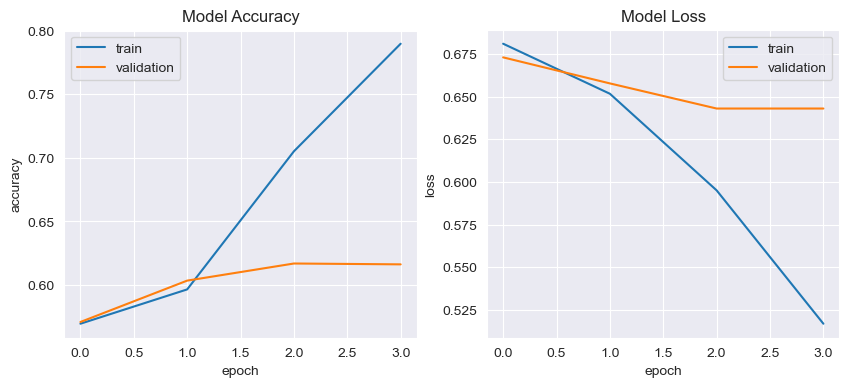

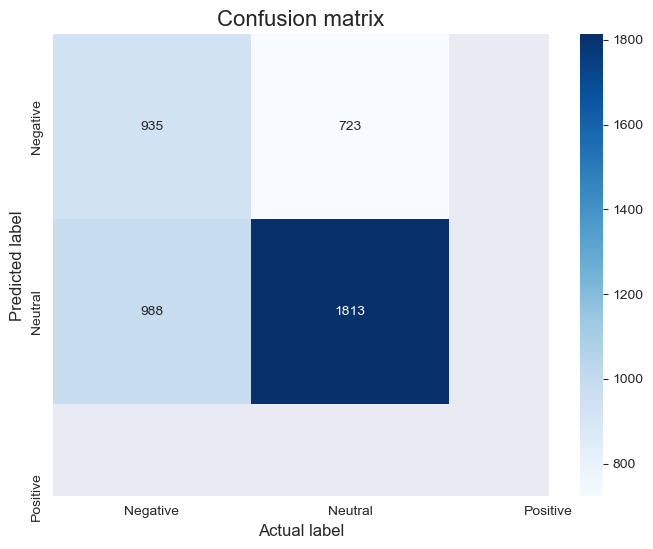

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
X = df['cleaned_tweets']
y = pd.get_dummies(df['crypto_sentiment']).values
num_classes = df['crypto_sentiment'].nunique()

seed = 1 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#max_features = 20000
# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(X_train))
# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)

# BOWs
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

num_input = X_train.shape[1]
from tensorflow.keras.preprocessing import sequence

max_words = 30
# X_train = sequence.pad_sequences(X_train, maxlen=max_words)
# X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape, X_test.shape)
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

batch_size = 32
epochs = 4

max_features = 20000
embed_dim = 100


np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.optimizer.learning_rate = 1e-4
model.build((None,X_train.shape[1]))
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=epochs, batch_size=batch_size, verbose=2)


def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')


plot_training_hist(history)
# predict class with test set
y_pred_test = np.argmax(model.predict(X_test), axis=1)
np.savetxt("y_predict_2.csv", y_pred_test, delimiter=",")
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test, axis=1), y_pred_test) * 100))
print(classification_report(np.argmax(y_test,axis=1), y_pred_test, digits = 4))
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(np.array(y_test), axis=1))

    print(pd.Series(np.argmax(np.array(y_test), axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())

    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)


plot_confusion_matrix(model, X_test, y_test)

## Model3 - embedding to semantics

(17833,) (4459,) (17833, 3) (4459, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 dense (Dense)               (None, 30, 16)            1616      
                                                                 
 dense_1 (Dense)             (None, 30, 16)            272       
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                  

INFO:tensorflow:Assets written to: ann\assets


140/140 [==============================] - 0s 1ms/step
Accuracy:	93.6%
              precision    recall  f1-score   support

           0     0.8675    0.6958    0.7723       480
           1     0.9456    0.9734    0.9593      1802
           2     0.9401    0.9582    0.9490      2177

    accuracy                         0.9361      4459
   macro avg     0.9177    0.8758    0.8935      4459
weighted avg     0.9345    0.9361    0.9341      4459



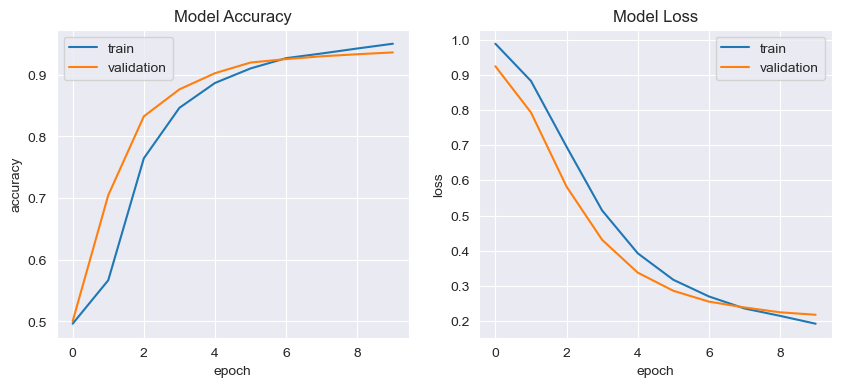

In [109]:
from sklearn.feature_extraction.text import CountVectorizer
X = df['cleaned_tweets']
y = pd.get_dummies(df['sentiment']).values
num_classes = df['sentiment'].nunique()

seed = 1 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#max_features = 20000
# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(X_train))
# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
from tensorflow.keras.preprocessing import sequence

max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)



import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, GRU, SimpleRNN
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

batch_size = 32
#cnn
#epochs = 15
#cnn-lstm
#epochs = 5
#epochs = 15
#ann
#epochs =20
epochs =10

max_features = 20000
embed_dim = 100
neurons = 64

np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))

model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.25))

# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.25))

# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.25))

# model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(32)))
#model.add(Dropout(0.25))


# model.add(GRU(256, return_sequences=True))
# model.add(SimpleRNN(128))
# model.add(Dense(10))
# model.add(Dropout(0.25))

# model.add(LSTM(256))
# model.add(Dense(10))
# model.add(Dropout(0.25))

# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(256))
# model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.optimizer.learning_rate = 1e-4
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=epochs, batch_size=batch_size, verbose=2)


def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')


plot_training_hist(history)
# predict class with test set
model.save('ann')
y_pred_test = np.argmax(model.predict(X_test), axis=1)
np.savetxt("ann_predict.csv", y_pred_test, delimiter=",")
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test, axis=1), y_pred_test) * 100))
print(classification_report(np.argmax(y_test, axis=1), y_pred_test, digits=4))
# from sklearn.metrics import confusion_matrix
# import seaborn as sns


# def plot_confusion_matrix(model, X_test, y_test):
#     '''Function to plot confusion matrix for the passed model and the data'''
#
#     sentiment_classes = ['Negative', 'Neutral', 'Positive']
#     # use model to do the prediction
#     y_pred = model.predict(X_test)
#     # compute confusion matrix
#     cm = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(np.array(y_test), axis=1))
#
#     print(pd.Series(np.argmax(np.array(y_test), axis=1)).value_counts())
#     print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
#
#     # plot confusion matrix
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
#                 xticklabels=sentiment_classes,
#                 yticklabels=sentiment_classes)
#     plt.title('Confusion matrix', fontsize=16)
#     plt.xlabel('Actual label', fontsize=12)
#     plt.ylabel('Predicted label', fontsize=12)
#
#
# plot_confusion_matrix(model, X_test, y_test)

## BOWs semantics

(17833,) (4459,) (17833, 3) (4459, 3)
(17833, 34948) (4459, 34948)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                559184    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 559,507
Trainable params: 559,507
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/d

E:\conda\envs\mlp\lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


558/558 - 3s - loss: 1.0034 - accuracy: 0.5044 - val_loss: 0.8973 - val_accuracy: 0.7416 - 3s/epoch - 5ms/step
Epoch 2/15
558/558 - 1s - loss: 0.8383 - accuracy: 0.6510 - val_loss: 0.7454 - val_accuracy: 0.7964 - 1s/epoch - 3ms/step
Epoch 3/15
558/558 - 1s - loss: 0.6991 - accuracy: 0.7456 - val_loss: 0.6309 - val_accuracy: 0.8219 - 1s/epoch - 2ms/step
Epoch 4/15
558/558 - 1s - loss: 0.5793 - accuracy: 0.8088 - val_loss: 0.5332 - val_accuracy: 0.8405 - 1s/epoch - 2ms/step
Epoch 5/15
558/558 - 1s - loss: 0.4710 - accuracy: 0.8553 - val_loss: 0.4574 - val_accuracy: 0.8569 - 1s/epoch - 3ms/step
Epoch 6/15
558/558 - 1s - loss: 0.3851 - accuracy: 0.8870 - val_loss: 0.4036 - val_accuracy: 0.8677 - 1s/epoch - 3ms/step
Epoch 7/15
558/558 - 1s - loss: 0.3227 - accuracy: 0.9087 - val_loss: 0.3674 - val_accuracy: 0.8771 - 1s/epoch - 3ms/step
Epoch 8/15
558/558 - 1s - loss: 0.2740 - accuracy: 0.9228 - val_loss: 0.3406 - val_accuracy: 0.8865 - 1s/epoch - 3ms/step
Epoch 9/15
558/558 - 1s - loss: 0.2

INFO:tensorflow:Assets written to: bows\assets


140/140 [==============================] - 0s 792us/step
Accuracy:	89.9%
              precision    recall  f1-score   support

           0     0.9016    0.4771    0.6240       480
           1     0.8784    0.9584    0.9167      1802
           2     0.9169    0.9430    0.9298      2177

    accuracy                         0.8991      4459
   macro avg     0.8990    0.7928    0.8235      4459
weighted avg     0.8997    0.8991    0.8916      4459

140/140 [==============================] - 0s 892us/step
2    2177
1    1802
0     480
dtype: int64
2    2239
1    1966
0     254
dtype: int64


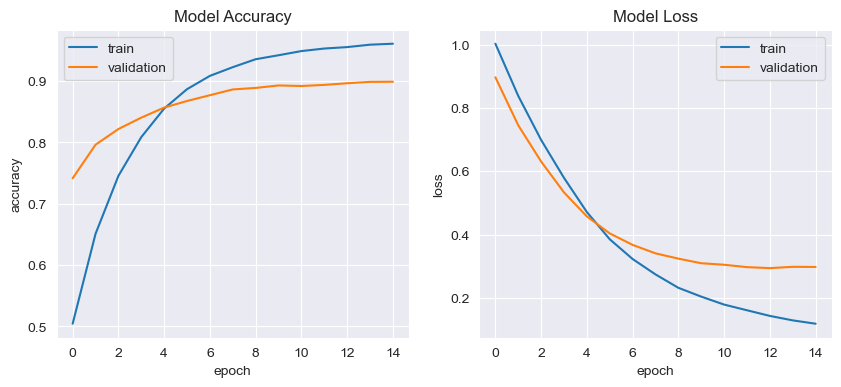

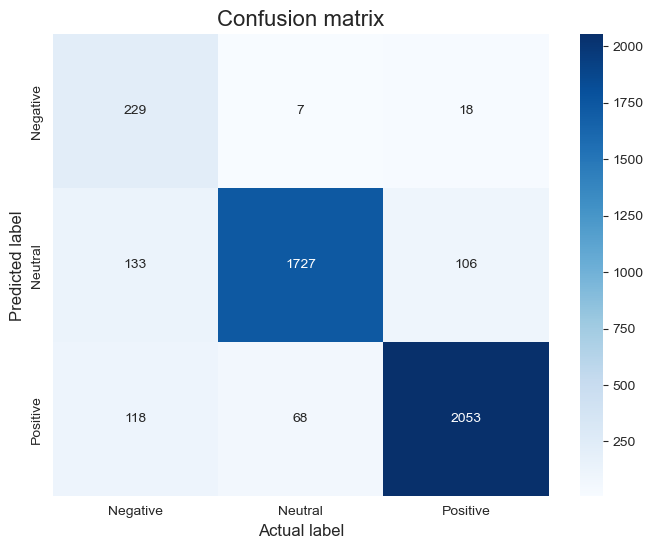

In [97]:
from sklearn.feature_extraction.text import CountVectorizer
X = df['cleaned_tweets']
y = pd.get_dummies(df['sentiment']).values
num_classes = df['sentiment'].nunique()

seed = 1 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#max_features = 20000
# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(X_train))
# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)

# BOWs
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

num_input = X_train.shape[1]
from tensorflow.keras.preprocessing import sequence

max_words = 30
# X_train = sequence.pad_sequences(X_train, maxlen=max_words)
# X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape, X_test.shape)
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

batch_size = 32
epochs = 15

max_features = 20000
embed_dim = 100


np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.optimizer.learning_rate = 1e-4
model.build((None,X_train.shape[1]))
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=epochs, batch_size=batch_size, verbose=2)


def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')


plot_training_hist(history)
# predict class with test set
model.save('bows')
y_pred_test = np.argmax(model.predict(X_test), axis=1)
np.savetxt("bows_predict.csv", y_pred_test, delimiter=",")
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test, axis=1), y_pred_test) * 100))
print(classification_report(np.argmax(y_test, axis=1), y_pred_test, digits=4))
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(np.array(y_test), axis=1))

    print(pd.Series(np.argmax(np.array(y_test), axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())

    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)


plot_confusion_matrix(model, X_test, y_test)

## Model - ensemble

In [115]:
ann_embedding_model = load_model("ann")
cnn_model = load_model("cnn")
bows_model = load_model("bows")

from sklearn.feature_extraction.text import CountVectorizer
X = df['cleaned_tweets']
y = pd.get_dummies(df['sentiment']).values
num_classes = df['sentiment'].nunique()

seed = 1 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)

# BOWs
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_test_bows = vectorizer.transform(X_test)

# embeddings
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_test_em = tokenizer.texts_to_sequences(X_test)
max_words = 30
X_test_em = sequence.pad_sequences(X_test_em, maxlen=max_words)

predict1 = ann_embedding_model(X_test_em)
predict2 = cnn_model.predict(X_test_em)
predict3 = bows_model.predict(X_test_bows)

y_pred_test = np.argmax(predict1, axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test, axis=1), y_pred_test) * 100))
print(classification_report(np.argmax(y_test, axis=1), y_pred_test, digits=4))


140/140 [==============================] - 0s 905us/step
Accuracy:	93.6%
              precision    recall  f1-score   support

           0     0.8675    0.6958    0.7723       480
           1     0.9456    0.9734    0.9593      1802
           2     0.9401    0.9582    0.9490      2177

    accuracy                         0.9361      4459
   macro avg     0.9177    0.8758    0.8935      4459
weighted avg     0.9345    0.9361    0.9341      4459



In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=epochs, batch_size=batch_size, verbose=2)


def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')


plot_training_hist(history)
# predict class with test set
y_pred_test = np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test, axis=1), y_pred_test) * 100))
print(classification_report(np.argmax(y_test, axis=1), y_pred_test))
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(np.array(y_test), axis=1))

    print(pd.Series(np.argmax(np.array(y_test), axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())

    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)


plot_confusion_matrix(model, X_test, y_test)


## Model4

In [1]:
num_samples = df.shape[0]
p = np.array(df['polarity']).reshape(num_samples,1).astype(np.float32)
s = np.array(df['subjectivity']).reshape(num_samples,1).astype(np.float32)
X = p
fa = np.array(df["user_favourites"]).reshape(22279,1).astype(np.float32)
fo = np.array(df['user_followers']).reshape(22279,1).astype(np.float32)
X = np.concatenate((X,s), axis=1)
X = np.concatenate((X,fa), axis=1)
X = np.concatenate((X,fo), axis=1)
y = pd.get_dummies(df['crypto_sentiment']).values
num_classes = df['crypto_sentiment'].nunique()


seed = 1 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

batch_size = 32
epochs = 100

max_features = 20000
embed_dim = 100

np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Dense(100, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.optimizer.learning_rate = 1e-5
model.build((None,2))
model.summary()

NameError: name 'df' is not defined

In [ ]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=epochs, batch_size=batch_size, verbose=2)


def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')


plot_training_hist(history)
# predict class with test set
y_pred_test = np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test, axis=1), y_pred_test) * 100))
print(classification_report(np.argmax(y_test, axis=1), y_pred_test))
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(np.array(y_test), axis=1))

    print(pd.Series(np.argmax(np.array(y_test), axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())

    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)


plot_confusion_matrix(model, X_test, y_test)


 ## Fitting test

In [ ]:
import pandas as pd
df = pd.read_csv('ann.csv', sep=',', header=None)
print(df.values)